# Determine bbg ffill limit

In [1]:
import pandas as pd
from pandas.tseries.offsets import BDay
import numpy as np
from dbtools.src.db_connexion import SqlConnector
import dbtools.src.get_repository as rep
from copy import deepcopy
connector = SqlConnector()
con_mis = connector.connection()
from tqdm import tqdm
from matplotlib import pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

## Load data 

In [2]:
## Load data from SQL
df_data_dict = pd.read_sql("""select attribute_id, name
                               from QUANT_work..FUNDAMENTAL_DATA_DICTIONARY""", con_mis)
df_data_dict = df_data_dict.set_index('attribute_id')['name']
df_daily_db = pd.read_sql('select * from QUANT_work..FUNDAMENTAL_DATA_STOCK_daily_api_test_100_stocks', con_mis)
df_daily_db.DATE = pd.to_datetime(df_daily_db.DATE)
df_daily_db.attribute_id = df_daily_db.attribute_id.replace(df_data_dict)
df_daily = df_daily_db.set_index(['DATE', 'attribute_id', 'security_id'])
df_daily_ts = df_daily_db.set_index(['security_id', 'attribute_id', 'DATE']).value.unstack().T

In [3]:
# separate 1gy, 2gy, bf data
df_1gy = df_daily_db[df_daily_db.attribute_id=='eps_1gy'].set_index(['DATE', 'security_id']).value.unstack()
df_2gy = df_daily_db[df_daily_db.attribute_id=='eps_2gy'].set_index(['DATE', 'security_id']).value.unstack()
df_bf = df_daily_db[df_daily_db.attribute_id=='eps_bf'].set_index(['DATE', 'security_id']).value.unstack()

sec_common = df_1gy.columns.intersection(df_2gy.columns).intersection(df_bf.columns)
date_common = pd.bdate_range('20220101', '20231231')
# keep securities listed since 20220101
listing_date =pd.to_datetime (rep.mapping_from_security(sec_common, code = 'begin_date_min'))
listing_date = listing_date[listing_date<=pd.to_datetime('20220101')]
sec_common = listing_date.index
ticker = rep.mapping_from_security(sec_common, 'fund_ticker')

df_1gy = df_1gy.reindex(index = date_common, columns = sec_common)
df_2gy = df_2gy.reindex(index = date_common, columns = sec_common)
df_bf = df_bf.reindex(index = date_common, columns = sec_common)
df_bf_db = df_bf.stack()

In [4]:
# count NA per securities
df_na = pd.concat((df_1gy.isna().sum(), df_2gy.isna().sum(), df_bf.isna().sum()), axis =1)
df_na.columns = ['1gy','2gy','bf']

## 3 cas aléatoires à étudier 

In [5]:
# Number of NAs of case study
print('Number of NAs of case study')
sec_case = [25, 34280, 10172537]
print(ticker[sec_case].to_frame('ticker').T.to_string())
df_na.loc[sec_case]

Number of NAs of case study
       25       34280     10172537
ticker    BB FP  LECN SW  NORBB SS


1gy  2gy   bf
25        408  410    0
34280     519  519  456
10172537  458  459    0

#### Cas 1, security 25, BB FP
408 sur 520 observations (soit 80%) des GY sont NA mais aucun NA sur BF
=> L'écart le plus grand entre 2 observation est 34 jours

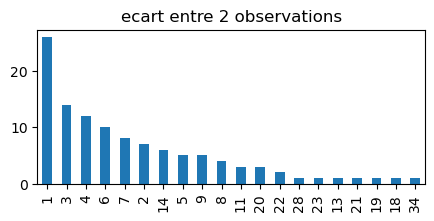

In [6]:
sec = 25
df_tmp = pd.concat((df_1gy[sec], df_2gy[sec], df_bf[sec]), axis =1)
df_tmp.columns = ['1gy','2gy','bf']
df_tmp = df_tmp.dropna(how = 'all')
df_tmp_bf = df_tmp.dropna(how = 'all')
df_tmp = df_tmp.dropna(subset = ['1gy','2gy'], how = 'all')
ecart = df_tmp.index.union([df_tmp_bf.index[-1]])
ecart = pd.Series(index = ecart, data = ecart.diff()).shift(-1)
ecart = ecart.sort_values().dropna().dt.days
ecart.value_counts().plot.bar(figsize = (5,2), title = 'ecart entre 2 observations')
plt.plot()
df_tmp['nb_days_ffill'] = ecart

#### case 2: security 34280 LECN SW
1 seule observation des GY le 2023-10-03, et BF est dispo à partir de cette date (64 observations)

=> Il y a minimum 64 ffill (soit 87 jours avec les we)

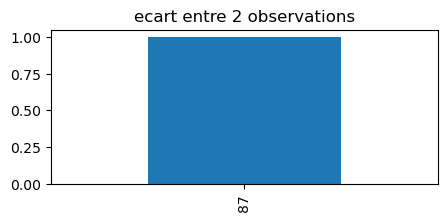

In [7]:
sec = 34280
df_tmp = pd.concat((df_1gy[sec], df_2gy[sec], df_bf[sec]), axis =1)
df_tmp.columns = ['1gy','2gy','bf']
df_tmp = df_tmp.dropna(how = 'all')
df_tmp_bf = df_tmp.dropna(how = 'all')
df_tmp = df_tmp.dropna(subset = ['1gy','2gy'], how = 'all')
ecart = df_tmp.index.union([df_tmp_bf.index[-1]])
ecart = pd.Series(index = ecart, data = ecart.diff()).shift(-1)
ecart = ecart.sort_values().dropna().dt.days
ecart.value_counts().plot.bar(figsize = (5,2), title = 'ecart entre 2 observations')
plt.plot()
df_tmp['nb_days_ffill'] = ecart

#### case 3: security 10172537 NORBB SS

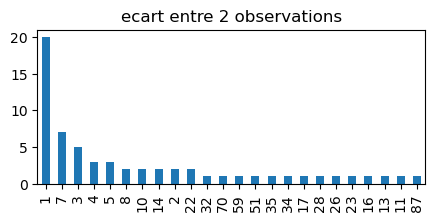

In [8]:
sec = 10172537
df_tmp = pd.concat((df_1gy[sec], df_2gy[sec], df_bf[sec]), axis =1)
df_tmp.columns = ['1gy','2gy','bf']
df_tmp = df_tmp.dropna(how = 'all')
df_tmp_bf = df_tmp.dropna(how = 'all')
df_tmp = df_tmp.dropna(subset = ['1gy','2gy'], how = 'all')
ecart = df_tmp.index.union([df_tmp_bf.index[-1]])
ecart = pd.Series(index = ecart, data = ecart.diff()).shift(-1)
ecart = ecart.sort_values().dropna().dt.days
ecart.value_counts().plot.bar(figsize = (5,2), title = 'ecart entre 2 observations')
plt.plot()
df_tmp['nb_days_ffill'] = ecart

## Les cas où les stocks sont NA le 29-12-2023 (dernier jours de l'échantillon)
C'est les cas où le ffill est appliqué avec une certaine limite.

C'est les cas spéciaux, par ex: sec 15210, GIMB BB

* Le 2023-11-27, on a les données 1GY, 2GY missing (dernier jour dispo 2023-09-21), mais BF est manquant?
* Les données chargées lors de la dernier screener sont TOUTES dispo pour BF

***C'est pareil pour 673005 et 10173378*** ça se trouve que c'est un erreur de bloomberg à la date de chargement de données

In [9]:
sec_na = df_bf.iloc[-1][df_bf.iloc[-1].isna()].sort_values().index
print(ticker[sec_na].to_frame('ticker').T.to_string())
df_na.loc[sec_na]

       15210    673005   10173378
ticker  GIMB BB   SEV FP   STH PW


1gy  2gy   bf
15210     514  516  387
673005    509  512  275
10173378  482  487   97

#### sec 15210, GIMB BB.
* ffill max est 100 jours.
* Le 2023-11-27, on a les données 1GY, 2GY missing (dernier jour dispo 2023-09-21), mais BF est manquant? **Comment expliquer?**
* Les données chargées lors de la dernier screener sont TOUTES dispo pour BF

1gy   2gy     bf  nb_days_ffill
2023-05-11  6.40   NaN    NaN           13.0
2023-05-24  5.15  5.51  5.205          100.0
2023-09-01  4.49  4.91  4.668            4.0
2023-09-05  4.39  4.99  4.651           16.0
2023-09-21  1.12  3.98  2.490           67.0
2023-11-27  5.66   NaN    NaN            NaN

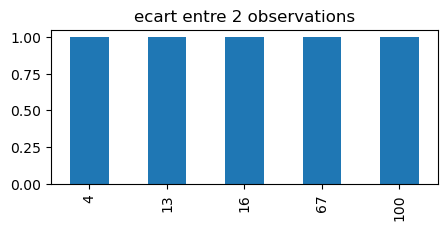

In [10]:
sec = 15210
df_tmp = pd.concat((df_1gy[sec], df_2gy[sec], df_bf[sec]), axis =1)
df_tmp.columns = ['1gy','2gy','bf']
df_tmp = df_tmp.dropna(how = 'all')
df_tmp_bf = df_tmp.dropna(how = 'all')
df_tmp = df_tmp.dropna(subset = ['1gy','2gy'], how = 'all')
ecart = df_tmp.index.union([df_tmp_bf.index[-1]])
ecart = pd.Series(index = ecart, data = ecart.diff()).shift(-1)
ecart = ecart.sort_values().dropna().dt.days
ecart.value_counts().plot.bar(figsize = (5,2), title = 'ecart entre 2 observations')
plt.plot()
df_tmp['nb_days_ffill'] = ecart
df_tmp

#### sec 673005, SEV FP, délisté 2022-02-18 (aquis par VIE FP)
**même commentaire que 15210, GIMB BB**
* ffill max est 98 jours.
* Le 2022-12-12, on a les données 1GY, 2GY missing (dernier jour dispo 2022-11-23), mais BF est manquant? **Comment expliquer?**
* Pourtant, les données chargées lors de la dernier screener sont dispo pour BF pour 2022-12-12

1gy    2gy     bf  nb_days_ffill
2022-01-03  0.957  1.083  0.958           21.0
2022-01-24  0.957    NaN  0.965            1.0
2022-01-25  0.957    NaN  0.966           13.0
2022-02-07  0.958  1.083  0.971            1.0
2022-02-08  0.957  1.100  0.972            6.0
2022-02-14  0.957  1.020  0.965           25.0
2022-03-11  0.957  1.020  0.969           66.0
2022-05-16  0.957  1.020  0.980           98.0
2022-08-22  0.957  1.020  0.997           93.0
2022-11-23  0.957  1.020  1.013           19.0
2022-12-12  0.957    NaN    NaN            NaN

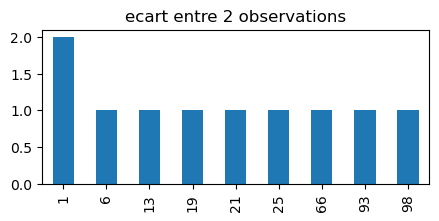

In [11]:
sec = 673005
df_tmp = pd.concat((df_1gy[sec], df_2gy[sec], df_bf[sec]), axis =1)
df_tmp.columns = ['1gy','2gy','bf']
df_tmp = df_tmp.dropna(how = 'all')
df_tmp_bf = df_tmp.dropna(how = 'all')
df_tmp = df_tmp.dropna(subset = ['1gy','2gy'], how = 'all')
ecart = df_tmp.index.union([df_tmp_bf.index[-1]])
ecart = pd.Series(index = ecart, data = ecart.diff()).shift(-1)
ecart = ecart.sort_values().dropna().dt.days
ecart.value_counts().plot.bar(figsize = (5,2), title = 'ecart entre 2 observations')
plt.plot()
df_tmp['nb_days_ffill'] = ecart
df_tmp

#### sec 10173378, STH PW, délisté 2024-02-07
**même commentaire que 15210, GIMB BB**
* ffill max est 75 jours.
* Le 2023-08-25, on a les données 1GY, 2GY missing (dernier jour dispo 2023-08-22), mais BF est manquant? **Comment expliquer?**
* Pourtant, les données chargées lors de la dernier screener sont dispo pour BF pour 2023-08-25

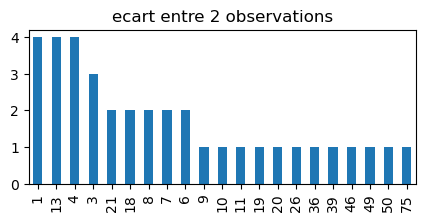

In [12]:
sec = 10173378
df_tmp = pd.concat((df_1gy[sec], df_2gy[sec], df_bf[sec]), axis =1)
df_tmp.columns = ['1gy','2gy','bf']
df_tmp = df_tmp.dropna(how = 'all')
df_tmp_bf = df_tmp.dropna(how = 'all')
df_tmp = df_tmp.dropna(subset = ['1gy','2gy'], how = 'all')
ecart = df_tmp.index.union([df_tmp_bf.index[-1]])
ecart = pd.Series(index = ecart, data = ecart.diff()).shift(-1)
ecart = ecart.sort_values().dropna().dt.days
ecart.value_counts().plot.bar(figsize = (5,2), title = 'ecart entre 2 observations')
plt.plot()
df_tmp['nb_days_ffill'] = ecart

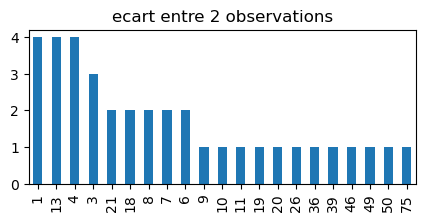

In [13]:
sec = 10173378
df_tmp = pd.concat((df_1gy[sec], df_2gy[sec], df_bf[sec]), axis =1)
df_tmp.columns = ['1gy','2gy','bf']
df_tmp_bf = df_tmp.dropna(how = 'all')
df_tmp = df_tmp.dropna(subset = ['1gy','2gy'], how = 'all')
ecart = df_tmp.index.union([df_tmp_bf.index[-1]])
ecart = pd.Series(index = ecart, data = ecart.diff()).shift(-1)
ecart = ecart.sort_values().dropna().dt.days
ecart.value_counts().plot.bar(figsize = (5,2), title = 'ecart entre 2 observations')
plt.plot()
df_tmp['nb_days_ffill'] = ecart

## Generaliser, calculer le nb de ffill max
nb max days ffill par stocks: pas de max days, mais pas dépasser l'année fiscale. Top 10 des stocks ffill

|             |   38760 |   2756821 |   2962159 |   328915 |   3018908 |   34195 |   12658 |   76654 |   2765679 |   15210 |
|:------------|--------:|----------:|----------:|---------:|----------:|--------:|--------:|--------:|----------:|--------:|
| nb_days_max |     339 |       199 |       199 |      170 |       167 |     131 |     120 |     115 |       114 |     100 |

In [21]:
df_ecart = pd.DataFrame(index = sec_common, columns = ['nb_days_max', 'day_from', 'day_to', 'same_year'])
for sec in sec_common:
    df_tmp = pd.concat((df_1gy[sec], df_2gy[sec], df_bf[sec]), axis =1)
    df_tmp.columns = ['1gy','2gy','bf']
    df_tmp_bf = df_tmp.dropna(how = 'all')
    df_tmp = df_tmp.dropna(subset = ['1gy','2gy'], how = 'all')
    
    ecart = df_tmp.index.union([df_tmp_bf.index[-1]])
    ecart = pd.Series(index = ecart, data = ecart.diff()).shift(-1)
    ecart = ecart.dropna().dt.days
    df_tmp['nb_days_ffill'] = ecart
    df_ecart.loc[sec, 'nb_days_max'] = ecart.max()
    day_from = pd.to_datetime(ecart.index[ecart.argmax()]) 
    day_to = pd.to_datetime(ecart.index[ecart.argmax()+1 if ecart.argmax()<len(ecart)-1 else -1]) + BDay(-1)
    df_ecart.loc[sec, 'day_from'] = day_from
    df_ecart.loc[sec, 'day_to'] = day_to
    df_ecart.loc[sec,'same_year'] = (day_from.year==day_to.year)*1

In [34]:
df_tmp.iloc[25:]

1gy    2gy     bf  nb_days_ffill
2022-06-30  4.777  5.144  4.960             11
2022-07-11  4.777  5.144  4.970             21
2022-08-01  4.777  5.144  4.991              1
2022-08-02  4.777  5.144  4.992              1
2022-08-03  4.856  5.256  5.092              1
...           ...    ...    ...            ...
2023-11-23  5.520  5.972  5.927              1
2023-11-24  5.507  5.957  5.914              3
2023-11-27  5.520  5.972  5.931              7
2023-12-04  5.520  5.972  5.939              3
2023-12-07  5.520  5.991  5.962             22

[87 rows x 4 columns]

In [15]:
df_ecart.sort_values(by = 'nb_days_max', ascending = False).head(10)

nb_days_max             day_from               day_to same_year
38760           339  2023-01-24 00:00:00  2023-01-23 00:00:00         1
2756821         199  2022-01-03 00:00:00  2022-07-20 00:00:00         1
2962159         199  2022-03-28 00:00:00  2022-10-12 00:00:00         1
328915          170  2023-02-27 00:00:00  2023-08-15 00:00:00         1
3018908         167  2023-04-07 00:00:00  2023-09-20 00:00:00         1
34195           131  2022-04-20 00:00:00  2022-08-26 00:00:00         1
12658           120  2022-05-12 00:00:00  2022-09-08 00:00:00         1
76654           115  2022-06-07 00:00:00  2022-09-29 00:00:00         1
2765679         114  2023-01-02 00:00:00  2023-04-25 00:00:00         1
15210           100  2023-05-24 00:00:00  2023-08-31 00:00:00         1

In [16]:
sec = 2757656
df_tmp = pd.concat((df_1gy[sec], df_2gy[sec], df_bf[sec]), axis =1)
df_tmp.columns = ['1gy','2gy','bf']
df_tmp.loc[df_ecart.loc[sec,'day_from']:df_ecart.loc[sec,'day_to']]
df_tmp.iloc[255:265]

1gy  2gy     bf
2022-12-26  NaN  NaN  6.388
2022-12-27  NaN  NaN  6.393
2022-12-28  NaN  NaN  6.397
2022-12-29  NaN  NaN  6.401
2022-12-30  NaN  NaN  6.404
2023-01-02  NaN  NaN  6.410
2023-01-03  NaN  NaN  6.414
2023-01-04  NaN  NaN  6.419
2023-01-05  NaN  NaN  6.423
2023-01-06  NaN  NaN  6.426

## Stocks dont ffill depassent l'année

In [17]:
df_ecart_max = pd.DataFrame()
df_year_ffil = pd.DataFrame()
for sec in sec_common:
    df_tmp = pd.concat((df_1gy[sec], df_2gy[sec], df_bf[sec]), axis =1)
    df_tmp.columns = ['1gy','2gy','bf']
    df_tmp_bf = df_tmp.dropna(how = 'all')
    df_tmp = df_tmp.dropna(subset = ['1gy','2gy'], how = 'all')
    
    ecart = df_tmp.index.union([df_tmp_bf.index[-1]])
    df_dates = pd.DataFrame(index = ['from','to'], columns = ecart[0:-1], data = [ecart[:-1], ecart[1:]+BDay(-1)]).T
    df_dates['nb_days_ffill'] = (df_dates['to']-df_dates['from']).dt.days
    df_dates['year_ffill'] = df_dates['to'].dt.year-df_dates['from'].dt.year
    df_tmp = pd.concat((df_tmp, df_dates), axis = 1)

    max_fill = df_tmp.iloc[[df_tmp.nb_days_ffill.argmax()]]
    max_fill['security_id'] = sec
    df_ecart_max = pd.concat((df_ecart_max, max_fill))
    year_ffill = df_tmp[~df_tmp.year_ffill.isin([0, np.nan])]
    if not year_ffill.empty:
        year_ffill['security_id'] = sec
        df_year_ffil = pd.concat((df_year_ffil, year_ffill))
df_ecart_max = df_ecart_max.set_index('security_id')
df_year_ffil = df_year_ffil.set_index('security_id')

In [18]:
df_year_ffil

1gy     2gy      bf       from         to  nb_days_ffill  \
security_id                                                                
258           5.600   6.133   5.776 2022-12-29 2023-01-02            4.0   
11963         6.180     NaN   7.210 2022-12-23 2023-01-02           10.0   
15726         3.590   3.745   3.696 2022-12-07 2023-01-04           28.0   
18590         4.634   6.818   5.978 2022-12-09 2023-01-06           28.0   
18678         3.257   3.648   3.354 2022-12-29 2023-01-03            5.0   
38718         0.125   0.139   0.133 2022-12-28 2023-01-10           13.0   
1037829      -0.444  -0.341  -0.438 2022-12-22 2023-01-03           12.0   
2632714      -0.370  -0.170  -0.224 2022-12-22 2023-01-04           13.0   
2752161      11.078  11.082  11.081 2022-12-23 2023-01-02           10.0   
2757656       5.830   6.977   6.199 2022-10-26 2023-01-06           72.0   
2764531       0.077   0.082   0.081 2022-12-22 2023-01-27           36.0   
2907194       0.067   0.094   0.089 2022-12-22 2023-01-09           18.0   
2925627       0.166   0.184   0.180 2022-12-14 2023-01-12           29.0   

             year_ffill  
security_id              
258                 1.0  
11963               1.0  
15726               1.0  
18590               1.0  
18678               1.0  
38718               1.0  
1037829             1.0  
2632714             1.0  
2752161             1.0  
2757656             1.0  
2764531             1.0  
2907194             1.0  
2925627             1.0

In [19]:
df_ecart_max

1gy     2gy      bf       from         to  nb_days_ffill  \
security_id                                                                
25            4.780   5.146   4.926 2022-05-25 2022-06-27           33.0   
31            3.004   3.641   3.602 2023-12-07 2023-12-28           21.0   
89            8.595  15.602  12.756 2023-08-03 2023-08-30           27.0   
210          31.827  35.417  33.197 2023-05-17 2023-06-02           16.0   
258           4.325   5.200   4.734 2022-02-17 2022-02-28           11.0   
...             ...     ...     ...        ...        ...            ...   
3012537       0.357   0.385   0.369 2022-06-02 2022-08-16           75.0   
3018908       0.673   1.978   1.024 2023-04-07 2023-09-20          166.0   
3031213       0.544   0.584   0.546 2022-01-20 2022-03-15           54.0   
10172537      3.067   3.293   3.145 2023-05-05 2023-07-28           84.0   
10173378      1.330   1.580   1.339 2022-01-12 2022-03-25           72.0   

             year_ffill  
security_id              
25                  0.0  
31                  0.0  
89                  0.0  
210                 0.0  
258                 0.0  
...                 ...  
3012537             0.0  
3018908             0.0  
3031213             0.0  
10172537            0.0  
10173378            0.0  

[91 rows x 7 columns]

In [20]:
df_ecart_max[df_ecart_max.nb_days_ffill>90]

1gy     2gy      bf       from         to  nb_days_ffill  \
security_id                                                                
12658         1.150   1.320   1.212 2022-05-12 2022-09-08          119.0   
13373        -0.227   0.107  -0.096 2023-05-22 2023-08-22           92.0   
15210         5.150   5.510   5.205 2023-05-24 2023-08-31           99.0   
34195        72.500  75.250  73.332 2022-04-20 2022-08-26          128.0   
38760         0.092   0.100   0.093 2023-01-24 2023-12-28          338.0   
76654        16.390  23.450  19.447 2022-06-07 2022-09-29          114.0   
328915        2.320   3.360   2.487 2023-02-27 2023-08-15          169.0   
658971       17.897   1.567   8.825 2022-07-21 2022-10-21           92.0   
673005        0.957   1.020   0.980 2022-05-16 2022-08-19           95.0   
2756821       3.130   3.010   3.129 2022-01-03 2022-07-20          198.0   
2765679      -3.628  -4.124  -3.632 2023-01-02 2023-04-25          113.0   
2962159      -0.880   0.040     NaN 2022-03-28 2022-10-12          198.0   
3018908       0.673   1.978   1.024 2023-04-07 2023-09-20          166.0   

             year_ffill  
security_id              
12658               0.0  
13373               0.0  
15210               0.0  
34195               0.0  
38760               0.0  
76654               0.0  
328915              0.0  
658971              0.0  
673005              0.0  
2756821             0.0  
2765679             0.0  
2962159             0.0  
3018908             0.0